# AxCaliber with time-dependent zeppelin

In this example, we use the AxCaliber method *(Assaf et al. 2008)* presented in a previous example while including the diffusion time-dependency of the extra-axonal space *(Novikov et al. 2014, Burcaw et al. 2015)*. 


The signal representation is 


\begin{equation}
E_{\textrm{AxCaliber}}^{\textrm{Temporal}}= \underbrace{(1-f_r)\overbrace{E_h(b,\textbf{n},\lambda_\parallel,D_{\infty},A)}^{\textrm{GPA-Zeppelin}}}_{\textrm{Extra-Axonal}} + \underbrace{f_r \overbrace{\Gamma(\alpha,\beta)}^{\textrm{Gamma Distribution}}*_{\mathbb{R}}\overbrace{E_r(\cdot|D_\perp)}^{\textrm{Cylinder}}}_{\textrm{Intra-Axonal}}
\end{equation}


where the cylinder was initially represented using the Callaghan model, but was later replaced with the more general Van Gelderen model *(Huang et al. 2015, De Santis et al. 2016)*. The initial Ball, which accounted for the extra-axonal signal, is replaced by the time-dependent Zeppelin *(De Santis et al, 2016)*. The formulation of the time-dependent Zeppelin is as follows:

\begin{equation}
 E_h(b,\textbf{n},\lambda_\parallel,D_{\infty},A)=\exp(-b\textbf{n}^T(\textbf{R}\textbf{D}^h_{\textrm{diag}}\textbf{R}^T)\textbf{n})\quad\textrm{with}\quad
 \textbf{D}^h_{\textrm{diag}}=
\begin{pmatrix}
  \lambda_\parallel & 0 & 0  \\
  0 & D_{\infty}+A\frac{\ln(\Delta/\delta)+3/2}{\Delta-\delta/3} & 0  \\
  0  & 0  & D_{\infty}+A\frac{\ln(\Delta/\delta)+3/2}{\Delta-\delta/3}
 \end{pmatrix}
\end{equation}

here the perpendicular diffusivity is now dependent on $\Delta$ and $\delta$, with $D_{\infty}$ the bulk diffusion constant and $A$ a characteristic coefficient for extra-axonal hindrence.

Our goal here is to reproduce the Monte Carlo simulations presented in *(De Santis et al, 2016)*, where they investigated the impact of including extra-axonal hindrence through the temporal zeppelin on axonal density and diameter estimation.

# AxCaliber model with time-dependent zeppelin

Using Dmipy, we can construct the time-dependent version of AxCaliber by calling `G3TemporalZeppelin` instead of the previously used `G1Ball`.  
As before, the Gamma-distributed Gaussian-Phase cylinders are instantiated by first calling the cylinder model, and then using it as input for the GammaDistributed model.

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions import distribute_models

temporal_zeppelin = gaussian_models.G3TemporalZeppelin()
cylinder = cylinder_models.C4CylinderGaussianPhaseApproximation()
gamma_cylinder = distribute_models.DD1GammaDistributed(models=[cylinder])

Then put the models together in a MultiCompartmentModel and display the parameters. Note that this model has a lot of parameters.

In [2]:
from dmipy.core import modeling_framework
temporal_AxCaliber = modeling_framework.MultiCompartmentModel(models=[temporal_zeppelin, gamma_cylinder])
temporal_AxCaliber.parameter_cardinality

OrderedDict([('G3TemporalZeppelin_1_mu', 2),
             ('DD1GammaDistributed_1_DD1Gamma_1_beta', 1),
             ('G3TemporalZeppelin_1_lambda_inf', 1),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par',
              1),
             ('DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu',
              2),
             ('G3TemporalZeppelin_1_A', 1),
             ('DD1GammaDistributed_1_DD1Gamma_1_alpha', 1),
             ('G3TemporalZeppelin_1_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1)])

The data we will fit is measured only along 2 gradients perpendicular to the fiber axis (along x and y axis). This means there is no data that provides information to fit parallel diffusivity "lambda_par" or the axon orientation "mu". 

So first, we make sure that the intra- and extra-axonal orientations are aligned and that their parallel diffusivities are equal by using the set_equal_parameter() :

In [3]:
temporal_AxCaliber.set_equal_parameter(
    'G3TemporalZeppelin_1_mu',
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_mu');
temporal_AxCaliber.set_equal_parameter(
    'G3TemporalZeppelin_1_lambda_par',
    'DD1GammaDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par');

Then to not fit these superfluous parameters, we fix the orientation mu along the z-axis and give lambda_par an arbitrary value (it will not affect the results). 

In [4]:
temporal_AxCaliber.set_fixed_parameter(
    'G3TemporalZeppelin_1_lambda_par', 1.5e-9)
temporal_AxCaliber.set_fixed_parameter(
    'G3TemporalZeppelin_1_mu', [0, 0])

Notice that we are now only fitting the volume fractions, the Gamma distribution parameters $\alpha$ and $\beta$, the bulk diffusivity $\lambda_\infty$ and the coefficient for extra-axonal hindrance $A$.

In [5]:
temporal_AxCaliber.parameter_names

['DD1GammaDistributed_1_DD1Gamma_1_beta',
 'G3TemporalZeppelin_1_lambda_inf',
 'G3TemporalZeppelin_1_A',
 'DD1GammaDistributed_1_DD1Gamma_1_alpha',
 'partial_volume_0',
 'partial_volume_1']

# Load Monte Carlo simulated data

Using Camino, we previously generated a substrate of Gamma-distributed cylinders and simulated the perpendicular acquisition scheme that was used by *(De Santis et al. 2016)*.

In [6]:
from dmipy.data import saved_data
acquisition_scheme, signal = saved_data.de_santis_camino_data()

Unlike De Santis et al who simulated STEAM acquistion scheme, we simulate a PGSE scheme considering their parameters: $\delta = 17$ ms, $\Delta = 48,60,80,100,120,140,160,180,195$ ms, 4 b-values $(500, 1000, 2000$ and $4000$ $s/mm^2$) and 2 unweighted images for each $\Delta$.

In [7]:
acquisition_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 54
number of b0 measurements: 18
number of DWI shells: 36

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |2         |0               |0                        |17.0       |48.0      |83.0 
1           |1         |500             |23                       |17.0       |48.0      |83.0 
2           |1         |999             |33                       |17.0       |48.0      |83.0 
3           |1         |2000            |47                       |17.0       |48.0      |83.0 
4           |1         |3999            |67                       |17.0       |48.0      |83.0 
5           |2         |0               |0                        |17.0       |60.0      |95.0 
6           |1         |500             |21                       |17.0       |60.0      |95.0 
7           |1         |1000            |29                       |17.0       |60.0      |95.0 
8           |1    

To estimate the robustness of the model's parameter estimates, we simulate 50 Rician noise instances on the data at SNR=30.

In [8]:
signal.shape

(50, 54)

# Fit time-dependent AxCaliber model to simulated data

In [9]:
temporal_AxCaliber_fit = temporal_AxCaliber.fit(
    acquisition_scheme, signal[:20], solver='mix', 
    maxiter=100, use_parallel_processing=False)

Setup MIX optimizer in 1.19209289551e-05 seconds
Fitting of 20 voxels complete in 627.656817913 seconds.
Average of 31.3828408957 seconds per voxel.


In [16]:
A_s = temporal_AxCaliber_fit.fitted_parameters['G3TemporalZeppelin_1_A']
fr_s = temporal_AxCaliber_fit.fitted_parameters['partial_volume_0']
D_inf_s = temporal_AxCaliber_fit.fitted_parameters['G3TemporalZeppelin_1_lambda_inf']
alpha_s = temporal_AxCaliber_fit.fitted_parameters['DD1GammaDistributed_1_DD1Gamma_1_alpha']
beta_s = temporal_AxCaliber_fit.fitted_parameters['DD1GammaDistributed_1_DD1Gamma_1_beta']

# Visualize fitted parameters

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
A_kernel = stats.gaussian_kde(A_s)
D_inf_kernel = stats.gaussian_kde(D_inf_s)
AD_s = 2 * alpha_s * beta_s
AD_kernel = stats.gaussian_kde(AD_s)
fr_kernel = stats.gaussian_kde(fr_s)

ind_A = np.linspace(A_s.min(), A_s.max(), 50)
ind_D_inf = np.linspace(D_inf_s.min(), D_inf_s.max(), 50)
ind_AD = np.linspace(AD_s.min(), AD_s.max(), 50)
ind_fr = np.linspace(fr_s.min(), fr_s.max(), 50)

In [31]:
ind_AD_s

array([  2.27166548e-08,   2.34254791e-07,   4.45792928e-07,
         6.57331064e-07,   8.68869201e-07,   1.08040734e-06,
         1.29194547e-06,   1.50348361e-06,   1.71502175e-06,
         1.92655988e-06,   2.13809802e-06,   2.34963616e-06,
         2.56117429e-06,   2.77271243e-06,   2.98425057e-06,
         3.19578870e-06,   3.40732684e-06,   3.61886498e-06,
         3.83040311e-06,   4.04194125e-06,   4.25347939e-06,
         4.46501752e-06,   4.67655566e-06,   4.88809379e-06,
         5.09963193e-06,   5.31117007e-06,   5.52270820e-06,
         5.73424634e-06,   5.94578448e-06,   6.15732261e-06,
         6.36886075e-06,   6.58039889e-06,   6.79193702e-06,
         7.00347516e-06,   7.21501330e-06,   7.42655143e-06,
         7.63808957e-06,   7.84962771e-06,   8.06116584e-06,
         8.27270398e-06,   8.48424212e-06,   8.69578025e-06,
         8.90731839e-06,   9.11885653e-06,   9.33039466e-06,
         9.54193280e-06,   9.75347093e-06,   9.96500907e-06,
         1.01765472e-05,

We use the gaussian_kde function to show the distribution of the fitted parameters. For each figure, the red vertical line is the ground truth while the green vertical one represents the mean value of the estimated parameter.

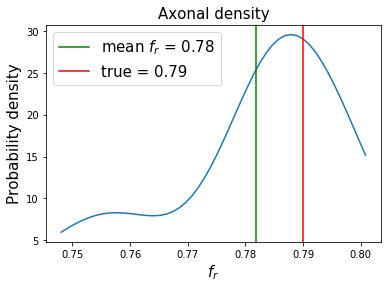

In [19]:
plt.title('Axonal density', fontsize=15)
plt.plot(ind_fr, fr_kernel(ind_fr))
plt.axvline(fr_s.mean(), c='g', label='mean $f_r$ = '+str(np.round(fr_s.mean(), 2)))
plt.axvline(0.79, c='r', label='true = 0.79')
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('$f_r$', fontsize=15)
plt.legend(fontsize=15, loc=2)
plt.show()

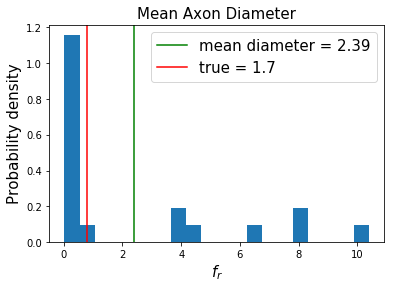

In [40]:
plt.title('Mean Axon Diameter', fontsize=15)
plt.hist(1e6 * AD_s, normed=True, bins=20)
plt.axvline(1e6 * AD_s.mean(), c='g', label='mean diameter = '+str(np.round(1e6 * AD_s.mean(), 2)))
plt.axvline(0.79, c='r', label='true = 1.7')
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('$f_r$', fontsize=15)
plt.legend(fontsize=15, loc=1)
plt.show()

Notice that the estimated mean axon diameter either defaults to "Stick-like" behavior or finds axon diameter much too large. The mean is therefore mostly outlier driven.

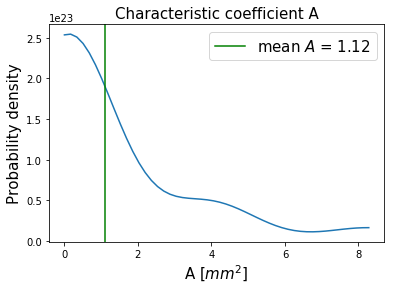

In [23]:
plt.plot(ind_A*1e12, A_kernel(ind_A)*1e12)
plt.axvline(A_s.mean()*1e12, c='g', label='mean $A$ = '+str(np.round(A_s.mean()*1e12, 2)))
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('A [$mm^2$]', fontsize=15)
plt.title('Characteristic coefficient A', fontsize=15)
plt.legend(fontsize=15)
plt.show()

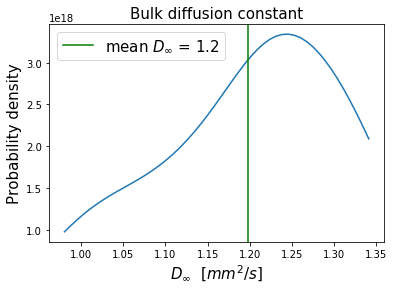

In [24]:
plt.title('Bulk diffusion constant', fontsize=15)
plt.plot(ind_D_inf*1e9, D_inf_kernel(ind_D_inf)*1e9)
plt.axvline(D_inf_s.mean()*1e9, c='g', label='mean $D_{\infty}$ = '+str(np.round(D_inf_s.mean()*1e9, 2)))
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('$D_{\infty}$  [$mm^2/s$]', fontsize=15)
plt.legend(fontsize=15)
plt.show()

Except for the axon diameter estimation, our results are comparable to De Santis et al results (of the 3rd simulation presented in table 1). Indeed,
the mean of the estmated axonal density $f_r$ is close to the ground truth, however, with this scheme, the axonal diameter is badly estimated.

As for the characteristic coefficient A, the estimated value is very close to De Santis et al, while its variance is a bit larger. And the mean of the estimated bulk diffision constant $D_{\infty}$ is 3 times bigger. Further study is needed to explain the differences between De Santis et al's findings and ours.

## References
- Assaf, Yaniv, et al. "AxCaliber: a method for measuring axon diameter distribution from diffusion MRI." Magnetic resonance in medicine 59.6 (2008): 1347-1354.
- Novikov, Dmitry S., et al. "Revealing mesoscopic structural universality with diffusion." Proceedings of the National Academy of Sciences 111.14 (2014): 5088-5093.
- Huang, Susie Y., et al. "The impact of gradient strength on in vivo diffusion MRI estimates of axon diameter." NeuroImage 106 (2015): 464-472.
- Burcaw, Lauren M., Els Fieremans, and Dmitry S. Novikov. "Mesoscopic structure of neuronal tracts from time-dependent diffusion." NeuroImage 114 (2015): 18-37.
- De Santis, Silvia, Derek K. Jones, and Alard Roebroeck. "Including diffusion time dependence in the extra-axonal space improves in vivo estimates of axonal diameter and density in human white matter." NeuroImage 130 (2016): 91-103.
